In [16]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

np.set_printoptions(precision=3, linewidth=500, threshold=500, suppress=True, edgeitems=5)

pd.set_option('display.max_rows', 60)
pd.set_option('display.min_rows', 30)
pd.set_option('display.width', 200)
pd.set_option('display.max_columns', 40)

%load_ext autoreload
%autoreload 2

%matplotlib inline


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from ndgsp.models.reconstruction import GSR
from ndgsp.models.regression.rnc import RNC
from ndgsp.graph.graphs import ProductGraph
from ndgsp.graph.filters import MultivariateFilterFunction
from ndgsp.algorithms.cgm import solve_SPCGM

from pykronecker import KroneckerDiag, KroneckerIdentity

from scipy.optimize import minimize

2023-05-20 21:00:59.782292: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Using Jax backend with device TFRT_CPU_0


In [3]:
N = 10
T = 12
gamma = 1

np.random.seed(0)

Y = np.random.normal(size=(N, T))

S = np.random.randint(2, size=(N, T))

Y[~S.astype(bool)] = np.nan

DS = np.diag(S.reshape(-1))

In [4]:
graph = ProductGraph.lattice(N, T)
ffunc = MultivariateFilterFunction.diffusion(beta=[0.5, 0.7])
G = ffunc(graph.lams)
H = graph.U @ np.diag(G.reshape(-1)) @ graph.U.T
Hi = np.linalg.inv(H)
cov_true = np.linalg.inv(DS +  gamma * Hi @ Hi)
var_true = np.diag(cov_true).reshape(N, T)

Omega = np.log(var_true)


In [5]:
DG = KroneckerDiag(G)

def compute_omega_element(n, t):

    sig = np.zeros_like(Y)
    sig[n, t] = 1

    A_precon = DG @ graph.U.T @ KroneckerDiag(S) @ graph.U @ DG + gamma * KroneckerIdentity(like=DG)
    var, nits = solve_SPCGM(A_precon=A_precon, Y=sig, Phi=graph.U @ DG)

    return np.log(var[n, t])


compute_omega_element(0, 0)

-1.5844427

In [6]:
np.array([[compute_omega_element(n, t) for t in range(T)] for n in range(N)])

array([[-1.584, -2.084, -2.191, -2.153, -2.154, -2.211, -2.297, -2.316, -2.282, -2.251, -2.127, -1.641],
       [-2.089, -2.608, -2.751, -2.74 , -2.741, -2.76 , -2.757, -2.696, -2.666, -2.698, -2.634, -2.18 ],
       [-2.262, -2.739, -2.854, -2.864, -2.872, -2.866, -2.819, -2.735, -2.696, -2.7  , -2.609, -2.192],
       [-2.244, -2.691, -2.8  , -2.828, -2.845, -2.849, -2.824, -2.792, -2.777, -2.735, -2.554, -2.094],
       [-2.137, -2.579, -2.733, -2.761, -2.767, -2.79 , -2.774, -2.76 , -2.765, -2.742, -2.583, -2.117],
       [-2.132, -2.535, -2.644, -2.673, -2.729, -2.8  , -2.809, -2.775, -2.752, -2.734, -2.615, -2.193],
       [-2.125, -2.533, -2.639, -2.693, -2.773, -2.82 , -2.811, -2.77 , -2.756, -2.719, -2.587, -2.179],
       [-2.237, -2.656, -2.725, -2.77 , -2.817, -2.813, -2.805, -2.787, -2.789, -2.735, -2.56 , -2.127],
       [-2.189, -2.63 , -2.679, -2.718, -2.793, -2.817, -2.82 , -2.806, -2.76 , -2.68 , -2.572, -2.168],
       [-1.638, -2.103, -2.182, -2.212, -2.314, -2.375,

In [7]:
X1 = np.ones_like(Y)
X2 = (1 - S)
X3 = graph.filter(X2, ffunc)
X4 = (graph.U * graph.U) @ G
X5 = (graph.U * graph.U) @ (G ** 2)
X6 = graph.A @ np.ones_like(Y)
X7 = graph.filter(X6, ffunc)

X = np.array([X1.ravel(), X2.ravel(), X3.ravel(), X4.ravel(), X5.ravel(), X6.ravel(), X7.ravel()]).T

In [8]:
def get_Omega_Q_random(Q: int, seed=1):

    np.random.seed(seed)

    ix, iy = np.array(sum([[(n, t) for t in range(T)] for n in range(N)], []))[np.random.choice(N * T, size=Q)].T

    Omega_Q = np.zeros_like(Omega)
    Omega_Q[:] = np.nan
    Omega_Q[ix, iy] = Omega[ix, iy]

    return Omega_Q


# def mse(pred)


In [9]:
import time

In [10]:
Omega_Q = get_Omega_Q_random(50)

In [11]:
class RidgeRegression:

    def __init__(self, Omega_Q, X, lam=1) -> None:
        
        self.Q = (~np.isnan(Omega_Q)).astype(float)
        self.DQ = KroneckerDiag(self.Q)
        self.Omega_Q = np.nan_to_num(Omega_Q, nan=0, copy=True)
        self.X = X
        self.lam = lam

    def predict(self):

        return (self.X @ np.linalg.solve(self.X.T @ self.DQ @ self.X + self.lam * np.eye(self.X.shape[1]), self.X.T @ self.Omega_Q.ravel())).reshape(self.Omega_Q.shape)


class LFP:

    def __init__(self, Omega_Q, X, lam, graph, ffunc) -> None:
        
        self.Q = (~np.isnan(Omega_Q)).astype(float)
        self.Omega_Q = np.nan_to_num(Omega_Q, nan=0, copy=True)
        self.X = X
        self.lam = lam
        self.graph = graph
        self.ffunc = ffunc
        self.S_ = self.X[:, 1].reshape(self.Omega_Q.shape)
        self.NA = self.X[:, 5].reshape(self.Omega_Q.shape)
        

        if hasattr(ffunc.beta, '__len__'):
            self.beta_len = len(ffunc.beta)
            self.w0 = np.zeros(3 + 2 * self.beta_len)
            self.w0[3:3+self.beta_len] = np.log(ffunc.beta)
            self.w0[3+self.beta_len:] = np.log(ffunc.beta)
        else:
            self.beta_len = 1
            self.w0 = np.zeros(5)
            self.w0[3:] = ffunc.beta


    def predict(self, w):
        

        w1, w2, w3 = w[:3]

        if self.beta_len == 1:
            beta1, beta2 = np.exp(w[3:])

        else:

            beta1 = np.exp(w[3:3+self.beta_len])
            beta2 = np.exp(w[3+self.beta_len:])
        
        self.ffunc.set_beta(beta1)

        t2 = w2 * self.graph.filter(self.S_, self.ffunc)

        self.ffunc.set_beta(beta2)

        t3 = w3 * self.graph.filter(self.NA, self.ffunc)


        return w1 + t2 + t3
    
    def loss(self, w):

        pred = self.predict(w)

        l =  float(((self.Omega_Q - self.Q * pred) ** 2).sum() + self.lam * ((w - self.w0) ** 2).sum())

        print(f'params: {w}, loss: {l:.4e}', end='\r')

        return l

    def solve(self):

        sol = minimize(self.loss, [-0.01,  0.147, -0.712,  0.012,  0.037,  0.194,  0.017], method='Nelder-Mead')

        print(sol)

        return self.predict(sol.x)
    



In [12]:
Omega_Q = get_Omega_Q_random(100)

In [48]:
ffunc2 = MultivariateFilterFunction.diffusion(beta=[1, 1])

mod = GSR(Omega_Q, graph, ffunc2, gamma=1e-1, normalise=True)



<class 'numpy.ndarray'> <class 'numpy.ndarray'>


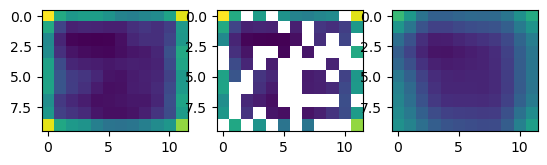

In [51]:
fig, axes = plt.subplots(ncols=3)

#
axes[0].imshow(Omega, vmin=Omega.min(), vmax=Omega.max())
axes[1].imshow(Omega_Q, vmin=Omega.min(), vmax=Omega.max())
axes[2].imshow(mod.denormalise(mod.compute_mean()), vmin=Omega.min(), vmax=Omega.max())

       message: Optimization terminated successfully..38 ], loss: 5.3701e-02
       success: True
        status: 0
           fun: 0.0537012554705143
             x: [-4.827e-01  8.273e-01 -6.614e-01 -5.468e-02  1.277e+00
                 -1.503e+00 -1.380e+00]
           nit: 603
          nfev: 928
 final_simplex: (array([[-4.827e-01,  8.273e-01, ..., -1.503e+00,
                        -1.380e+00],
                       [-4.827e-01,  8.273e-01, ..., -1.503e+00,
                        -1.380e+00],
                       ...,
                       [-4.826e-01,  8.272e-01, ..., -1.503e+00,
                        -1.380e+00],
                       [-4.826e-01,  8.272e-01, ..., -1.503e+00,
                        -1.380e+00]]), array([ 5.370e-02,  5.370e-02,  5.370e-02,  5.370e-02,
                        5.370e-02,  5.370e-02,  5.370e-02,  5.370e-02]))


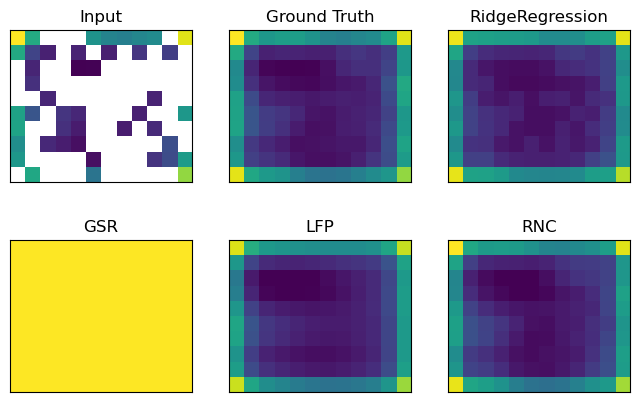

In [318]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(8, 5))

preds = {'Input': Omega_Q, 
         'Ground Truth': Omega, 
         'RidgeRegression': RidgeRegression(Omega_Q, X, lam=1).predict(),
         'GSR': GSR(Omega_Q, graph, ffunc, gamma=1).compute_mean(), 
         'RNC': RNC(X, Omega_Q, graph, ffunc, gamma=1, lam=1e-5).compute_mean(),
         'LFP': LFP(Omega_Q, X, 1e-5, graph, ffunc).solve()}


for ax, (name, value) in zip(axes.ravel(), preds.items()):

    ax.set_xticks([])
    ax.set_yticks([])

    ax.imshow(value, vmin=preds['Ground Truth'].min(), vmax=preds['Ground Truth'].max())
    ax.set_title(name)
